In [76]:
 
from bauer.utils.data import load_garcia2022
from bauer.models import FlexibleNoiseRiskModel
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


bids_folder = '/Users/mrenke/data/ds-miguel'

df = load_garcia2022(task='risk')
dataset = 'MiguelsData'

df['n_risky'] = np.where(df['p1']==0.55,df['n1'], df['n2'])
df['n_safe'] = np.where(df['p1']==1,df['n1'], df['n2'])

In [15]:
# for debugging, compare to numrisk dataframe

from utils import get_data

df = get_data('/Users/mrenke/data/ds-dnumrisk') # debug
dataset = 'dyscalculiaData'
df.set_index('n_safe', append=True, inplace=True)   


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


['n_safe range: ', array([14,  5, 10, 28, 20,  7])]
['n_risky mu & sd: ', 31.40539738048893, 23.45520202524752]


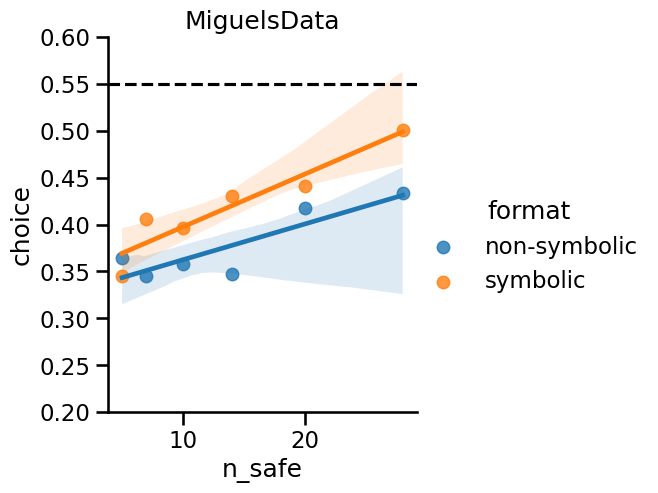

In [77]:
import seaborn as sns
sns.set_context('talk')

temp = df.groupby(['n_safe', 'format']).mean()

ax = sns.lmplot(data=temp.reset_index(), x='n_safe', y='choice', hue='format')
ax.set(ylim=[0.2,0.6],  title=dataset)
plt.axhline(0.55, ls='--', color='black')

print(['n_safe range: ', df.reset_index()['n_safe'].unique()])
print(['n_risky mu & sd: ', df.reset_index()['n_risky'].mean(), df.reset_index()['n_risky'].std()])


In [ ]:
import os.path as op    
import os

format = 'symbolic'
model_label = '2' # different priors! 
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')

if not op.exists(target_folder):
    os.makedirs(target_folder)

df = df.xs(format,0, level='format')

In [33]:
temp = df.groupby('n_safe').mean()
temp

,p1,n1,p2,n2,log(risky/safe),choice,n_risky
n_safe,,,,,,,
5,1.0,5.0,0.55,11.221776,0.723217,0.345119,11.221776
7,1.0,7.0,0.55,15.937725,0.730859,0.405988,15.937725
10,1.0,10.0,0.55,22.536855,0.723528,0.396137,22.536855
14,1.0,14.0,0.55,31.354265,0.714644,0.430885,31.354265
20,1.0,20.0,0.55,44.317665,0.703390,0.441441,44.317665
28,1.0,28.0,0.55,62.677014,0.710674,0.500982,62.677014


In [4]:
from bauer.models import RiskModel, RiskRegressionModel, RiskLapseModel

model = RiskModel(df, prior_estimate='full',fit_seperate_evidence_sd = False)
#model = RiskRegressionModel(df,regressors={}, prior_estimate='full',fit_seperate_evidence_sd = False)

#model = RiskLapseModel(df, prior_estimate='klw', fit_seperate_evidence_sd=False)

model.build_estimation_model()


burnin = 2000
samples  = 2000
target_accept = 0.9

import arviz as az

In [ ]:
trace = model.sample(burnin, samples, target_accept=target_accept)
# works when run in terminal, but not here (VSCode )  

az.to_netcdf(trace, op.join(target_folder, f'model-{model_label}_format-{format}_trace.netcdf'))

In [5]:
idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels_risk/model-{model_label}_format-{format}_trace.netcdf'))


In [32]:
from bauer.utils.bayes import softplus
import seaborn as sns   

target_folder = op.join(bids_folder, f'derivatives/cogmodels_risk/figures/{model_label}_format-{format}')
if not op.exists(target_folder):
    os.makedirs(target_folder)

for par in model.free_parameters:
    traces = idata.posterior[par+'_mu'].to_dataframe()
    if ('sd' in par):
        traces = softplus(traces)

    fig, ax = plt.subplots(1,1,figsize=(3,3))
    sns.kdeplot(traces, fill=True,legend=False,ax=ax)
    ax.set(xlabel = par)
    sns.despine()
    if par == 'risky_prior_mu':
        plt.axvline(np.log(df['n_risky']).mean(), c='k', ls='--')
    elif par == 'risky_prior_sd':
        plt.axvline(np.log(df['n_risky']).std(), c='k', ls='--')
    elif par == 'safe_prior_mu':
        for n_safe in np.log([7., 10., 14., 20., 28.]):
            plt.axvline(n_safe, c='k', ls='--')

        plt.axvline(np.log(df['n_safe']).mean(), c='k', ls='--', lw=2)
    elif par == 'safe_prior_sd':
        plt.axvline(np.log(df['n_safe']).std(), c='k', ls='--')
    
    plt.savefig(op.join(target_folder, f'group_par-{par}.pdf'), bbox_inches='tight')
    plt.close()

